<a href="https://colab.research.google.com/github/tienhuynh96/End-to-end-Question-Answering/blob/main/Question_Answering_Extractive_Approach_Transformer_based.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ***Question answering Extractive Approach with Transformer-based***

input_text = 'CSL' + question + ' sep ' + context

Backbone: Transformer

## **1. Import libraries and create temp datasets**

In [ ]:
import numpy as np
import torch
import torch.nn as nn
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import Dataset, DataLoader

/usr/local/lib/python3.10/dist-packages/torchtext/data/__init__.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated and the last released version will be 0.18 (this one). You can silence this warning by calling the following at the beginnign of your scripts: `import torchtext; torchtext.disable_torchtext_deprecation_warning()`
  warnings.warn(torchtext._TORCHTEXT_DEPRECATION_MSG)
/usr/local/lib/python3.10/dist-packages/torchtext/vocab/__init__.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated and the last released version will be 0.18 (this one). You can silence this warning by calling the following at the beginnign of your scripts: `import torchtext; torchtext.disable_torchtext_deprecation_warning()`
  warnings.warn(torchtext._TORCHTEXT_DEPRECATION_MSG)
/usr/local/lib/python3.10/dist-packages/torchtext/utils.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated

In [ ]:
qa_dataset = [
    {
        'context': 'My name is AIVN and I am from Vietnam.',
        'question': 'What is my name?',
        'answer': 'AIVN'
    },
    {
        'context': 'I love painting and my favorite artist is Vicent Van Gogh.',
        'question': 'What is my favorite activity?',
        'answer': 'painting'
    },
    {
        'context': 'I am studying computer science at the University of Tokyo.',
        'question': 'What am I Studying?',
        'answer': 'computer science'
    },
    {
        'context': 'My favorite book is "To kill a Mockingbird" by Harper Lee.',
        'question': 'What is my favorite book?',
        'answer': '"To kill a Mockingbird"'
    },
    {
        'context': 'I have a pet dog named Max who loves to play fetch',
        'question': 'What is the name of my pet?',
        'answer': 'Max'
    },
    {
        'context': 'I was born in Paris, but now I live in New york City',
        'question': 'Where do I live now?',
        'answer': 'New York City'
    }
    # {
    #     'context': '',
    #     'question': '',
    #     'answer': ''
    # },

]

data_size = len(qa_dataset)
data_size

6

In [ ]:
np.shape(qa_dataset)

(6,)

## **2. Build vocabulary**

In [ ]:
# Incase the question is non answerable, we can label start and end positions at <cls> token
# Define tokenizer function
tokenizer = get_tokenizer('basic_english')

# Create a function to yield list of tokens
# This yield function is required in function "build_vocab_from_iterator"
# Get data from item context and question in data
def yield_tokens(data):
  for item in data:
    yield tokenizer('<cls> ' + item['context'] + ' <sep> ' + item['question'])

# Create vocabulary
vocab = build_vocab_from_iterator(
    yield_tokens(qa_dataset),
    specials = ['<unk>','<pad>','<bos>','<eos>','<sep>','<cls>']
)

# Set default index for this vocab is 'unk' = 0, when the unknow word is replace the 'unk'
vocab.set_default_index(vocab['<unk>'])
# Build vocab (stoi mean string to index)
vocab.get_stoi()


{'vietnam': 59,
 'activity': 27,
 'to': 25,
 ',': 26,
 'pet': 22,
 'who': 62,
 'gogh': 40,
 'the': 24,
 'fetch': 38,
 'play': 53,
 'van': 57,
 'now': 20,
 'was': 60,
 'a': 15,
 'name': 14,
 'am': 13,
 'named': 49,
 'aivn': 28,
 'i': 6,
 'studying': 23,
 'and': 16,
 'where': 61,
 '<unk>': 0,
 'favorite': 12,
 'by': 33,
 'artist': 29,
 'live': 19,
 '<eos>': 3,
 'harper': 41,
 'dog': 37,
 'loves': 46,
 '.': 11,
 'born': 31,
 '<pad>': 1,
 'computer': 35,
 '<cls>': 5,
 'is': 7,
 'my': 8,
 'book': 17,
 'science': 54,
 'of': 21,
 '<bos>': 2,
 '<sep>': 4,
 'what': 10,
 'at': 30,
 'but': 32,
 'in': 18,
 'from': 39,
 'tokyo': 55,
 'city': 34,
 'vicent': 58,
 'have': 42,
 'kill': 43,
 'lee': 44,
 'love': 45,
 '?': 9,
 'do': 36,
 'max': 47,
 'mockingbird': 48,
 'york': 63,
 'new': 50,
 'painting': 51,
 'paris': 52,
 'university': 56}

In [ ]:
# Check
# Define tokenizer function
tokenizer = get_tokenizer('basic_english')

text = 'I love AIVN'
tokens = tokenizer(text)
tokens = [vocab[token] for token in tokens]
print(tokens)

[6, 45, 28]


## **3. Create vectorize function**

In [ ]:
# Pad an truncate
MAX_SEQ_LENGTH = 22
PAD_IDX = vocab['<pad>']

# define pad and truncate function
def pad_and_truncate(input_ids, max_seq_len):
  if len(input_ids) > max_seq_len:
    input_ids = input_ids[:max_seq_len]
  elif len(input_ids) < max_seq_len:
    input_ids += [PAD_IDX] * (max_seq_len - len(input_ids))

  return input_ids

In [ ]:
# Check
# Pad an truncate
MAX_SEQ_LENGTH = 22
PAD_IDX = vocab['<pad>']

text = 'I love AIVN'
tokens = tokenizer(text)
tokens = [vocab[token] for token in tokens]
print(tokens)
padded_tokens = pad_and_truncate(tokens, MAX_SEQ_LENGTH)
print(padded_tokens)


[6, 45, 28]
[6, 45, 28, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


In [ ]:
# Define vectorize function
def vectorize(question, context, answer):
  # input text  = cls + question + sep + context
  input_text = '<cls> ' + question + ' <sep> ' + context
  # Convert input to ids
  input_ids = [vocab[token] for token in tokenizer(input_text)]
  # pad and truncate input ids
  input_ids = pad_and_truncate(input_ids, MAX_SEQ_LENGTH)

  answer_ids = [vocab[token] for token in tokenizer(answer)]
  # Find the start position of answer in input text
  start_positions = input_ids.index(answer_ids[0])
  # Calculate the end position of answer in input text
  end_positions = start_positions + len(answer_ids) - 1

  # Convert data to tensor
  input_ids = torch.tensor(input_ids, dtype = torch.long)
  start_positions = torch.tensor(start_positions, dtype = torch.long)
  end_positions = torch.tensor(end_positions, dtype = torch.long)

  return input_ids, start_positions, end_positions



In [ ]:
#  Check function
MAX_SEQ_LENGTH = 22
input_ids, start_positions, end_positions  = vectorize(
    qa_dataset[0]['question'],
    qa_dataset[0]['context'],
    qa_dataset[0]['answer']
)

print(input_ids)
print(start_positions)
print(end_positions)

tensor([ 5, 10,  7,  8, 14,  9,  4,  8, 14,  7, 28, 16,  6, 13, 39, 59, 11,  1,
         1,  1,  1,  1])
tensor(10)
tensor(10)


## **4. Create datasets**

In [ ]:
class QADataset(Dataset):
  def __init__(self,data):
    self.data = data

  def __len__(self):
    return len(self.data)

  def __getitem__(self,idx):
    item = self.data[idx]
    question_text = item['question']
    context_text = item['context']
    answer_text = item['answer']

    input_ids, start_positions, end_positions = vectorize(question_text, context_text, answer_text)

    return   input_ids, start_positions, end_positions


In [ ]:
# Decode
# Define decode function: convert id to token
def decode(input_ids):
  return ' '.join([vocab.lookup_token(token) for token in input_ids])

In [ ]:
train_dataset = QADataset(qa_dataset)
train_loader = DataLoader(train_dataset, batch_size = 2, shuffle=True)

In [ ]:
next(iter(train_loader))

[tensor([[ 5, 61, 36,  6, 19, 20,  9,  4,  6, 60, 31, 18, 52, 26, 32, 20,  6, 19,
          18, 50, 63, 34],
         [ 5, 10,  7,  8, 12, 27,  9,  4,  6, 45, 51, 16,  8, 12, 29,  7, 58, 57,
          40, 11,  1,  1]]),
 tensor([19, 10]),
 tensor([21, 10])]

In [ ]:
decode(next(iter(train_loader))[0][0])


'<cls> what is my favorite book ? <sep> my favorite book is to kill a mockingbird by harper lee . <pad> <pad>'

In [ ]:

for batch in train_loader:
  input_ids, start_positions, end_positions = batch
  print (f'{decode(input_ids[1])} \n {input_ids[1]} \n {start_positions[1]} \n  {end_positions[1]} \n')
  answer = ' '.join(decode(input_ids[1]).split()[start_positions[1]: end_positions[1]+1])
  print(answer)


    #   context_tokens = tokenizer(context)
    # predicted_answer_tokens = context[start_position: end_position + 1]
    # predicted_answer = ' '.join(predicted_answer_tokens)

<cls> what is my favorite book ? <sep> my favorite book is to kill a mockingbird by harper lee . <pad> <pad> 
 tensor([ 5, 10,  7,  8, 12, 17,  9,  4,  8, 12, 17,  7, 25, 43, 15, 48, 33, 41,
        44, 11,  1,  1]) 
 12 
  15 

to kill a mockingbird
<cls> what am i studying ? <sep> i am studying computer science at the university of tokyo . <pad> <pad> <pad> <pad> 
 tensor([ 5, 10, 13,  6, 23,  9,  4,  6, 13, 23, 35, 54, 30, 24, 56, 21, 55, 11,
         1,  1,  1,  1]) 
 10 
  11 

computer science
<cls> what is my name ? <sep> my name is aivn and i am from vietnam . <pad> <pad> <pad> <pad> <pad> 
 tensor([ 5, 10,  7,  8, 14,  9,  4,  8, 14,  7, 28, 16,  6, 13, 39, 59, 11,  1,
         1,  1,  1,  1]) 
 10 
  10 

aivn


## **5. Create models**

### 5.1 Build Transformer block

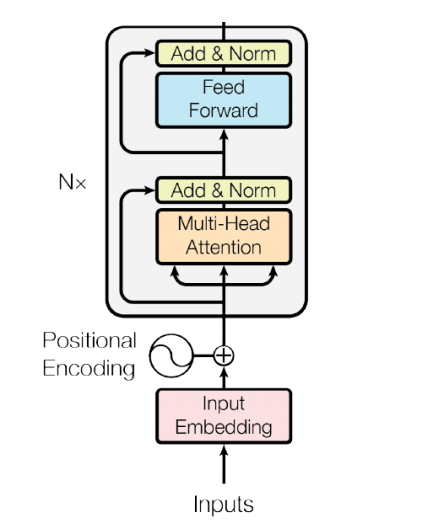

In [ ]:
# Build Transformer block
import math
import torch.nn as nn
import torch.optim as optim

class TransformerBlock(nn.Module):
  def __init__(self, embed_dim, num_heads, ff_dim):
    super().__init__()
    # Layer attention
    self.attn = nn.MultiheadAttention(embed_dim=embed_dim, num_heads=num_heads)
    # Layer feed forward
    self.ffn = nn.Linear(in_features=embed_dim, out_features=ff_dim)
    # Layer normalization 1
    self.layernorm_1 = nn.LayerNorm(normalized_shape=embed_dim)
    # Layer normalization 2
    self.layernorm_2 = nn.LayerNorm(normalized_shape=embed_dim)

  def forward(self, query, key, value):
    # Compute attetion step
    attn_output, _ = self.attn(query, key, value)
    # compute add and normalization 1
    out_1 = self.layernorm_1(query + attn_output)
    # compute feed forward
    ffn_output = self.ffn(out_1)
    # compute add and normalization 2
    x = self.layernorm_2(out_1 + ffn_output)

    return x

### 5.2 Build Positional encoding

In [ ]:
class PositionalEncoding(nn.Module):
  def __init__(self, d_model, max_len=5000):
    super(PositionalEncoding, self).__init__()
    pe = torch.zeros(max_len, d_model)
    position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
    div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
    pe[:,0::2] = torch.sin(position * div_term)
    pe[:,1::2] = torch.cos(position * div_term)
    pe = pe.unsqueeze(0).transpose(0, 1)
    self.register_buffer('pe',pe)

  def forward(self, x):
    x = x + self.pe[:x.size(0), :]
    return x

### 5.2 Create model

In [ ]:
# This model use Transformer
class QAModel(nn.Module):
  def __init__(self, vocab_size, embedding_dim, n_heads, ff_dim, max_len):
    super(QAModel, self).__init__()

    # Get embedding for input
    self.input_embedding = nn.Embedding(vocab_size, embedding_dim)
    # Get position
    self.pos_encoder = PositionalEncoding(embedding_dim, max_len)
    # Tranformer
    self.transformer = TransformerBlock(embedding_dim, n_heads, ff_dim)

    self.start_linear = nn.Linear(ff_dim, 1)
    self.end_linear = nn.Linear(ff_dim, 1)

  def forward(self, text):
    input_embedded = self.input_embedding(text)
    input_embedded = self.pos_encoder(input_embedded)

    transformer_out = self.transformer(input_embedded, input_embedded, input_embedded) #(output: bs, seq_len, hidden_units)

    # squeeze(-1) is removes the singleton dimension at the last position of the tensor
    # Logits (bs, 22, 1) => (bs, 22)
    start_logits = self.start_linear(transformer_out).squeeze(-1)
    end_logits = self.end_linear(transformer_out).squeeze(-1)

    return start_logits, end_logits




In [ ]:
# Model parameters
EMBEDDING_DIM = 128
FF_DIM = 128
N_HEADS = 1
VOCAB_SIZE = len(vocab)
MAX_SEQ_LENGTH = 512

model = QAModel(VOCAB_SIZE, EMBEDDING_DIM, N_HEADS, FF_DIM, MAX_SEQ_LENGTH)

input = torch.randint(0, 10, size=(1, 10)) # (size = 1, 10 =>  batch, sequence length)
print(input.shape)

model.eval()
with torch.no_grad():
  start_logits, end_logits = model(input)

print(start_logits.shape)

torch.Size([1, 10])
torch.Size([1, 10])


## **6. Training models**

In [ ]:
LR = 1e-3
EPOCHS = 10
optimizer = torch.optim.Adam(model.parameters(), lr=LR)
criterion = nn.CrossEntropyLoss()

In [ ]:

model.train()
for _ in range(EPOCHS):
  for idx, (input_ids, start_positions, end_positions) in enumerate(train_loader):
    optimizer.zero_grad()

    start_logits, end_logits = model(input_ids)

    start_loss = criterion(start_logits, start_positions)
    end_loss = criterion(end_logits, end_positions)
    total_loss = (start_loss + end_loss) / 2

    total_loss.backward()
    optimizer.step()
    print(total_loss.item())

5.876789093017578
5.467010498046875
5.259274482727051
4.723761558532715
4.018237590789795
3.192580223083496
3.414458751678467
2.571345329284668
2.6795287132263184
2.4022693634033203
2.1930203437805176
1.74578857421875
2.1870696544647217
1.6793185472488403
1.9749078750610352
1.3018386363983154
1.2045364379882812
2.485515832901001
0.803119421005249
0.7641465663909912
2.039639949798584
1.1034725904464722
0.48083218932151794
0.4340265989303589
0.7860057353973389
0.6795660257339478
0.29288244247436523
0.2008947730064392
0.27200186252593994
0.06398237496614456


## **7. Test**

In [ ]:
model.eval()
with torch.no_grad():
  sample = qa_dataset[2]
  context, question, answer = sample.values()
  input_ids, start_positions, end_positions = vectorize(question, context, answer)

  # Add batch
  input_ids = input_ids.unsqueeze(0)

  # Compute start and eng logits
  start_logits, end_logits = model(input_ids)

  # Compute offset is number tokens of question and <sep>
  offset = len(tokenizer(question)) + 2
  start_position = torch.argmax(start_logits, dim=1).numpy()[0]
  end_position = torch.argmax(end_logits, dim=1).numpy()[0]

  # minus to offset
  start_position -=offset
  end_position -=offset

  # set condition to start and end position
  start_position = max(start_position, 0)
  end_position = min(end_position, len(tokenizer(context)) - 1)

  # Check start and position
  if end_position >= start_position:
    # Extract the predicted answer span
    context_tokens = tokenizer(context)
    predicted_answer_tokens = context_tokens[start_position: end_position + 1]
    predicted_answer = ' '.join(predicted_answer_tokens)

  else:
    predicted_answer = ' '

  print(f'Context: {context}')
  print(f'Question: {question}')
  print(f'Start position: {start_position}')
  print(f'End position: {end_position}')
  print(f'Prediction: {predicted_answer}')

Context: I am studying computer science at the University of Tokyo.
Question: What am I Studying?
Start position: 3
End position: 4
Prediction: computer science


In [ ]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [ ]:
model

QAModel(
  (input_embedding): Embedding(64, 128)
  (pos_encoder): PositionalEncoding()
  (transformer): TransformerBlock(
    (attn): MultiheadAttention(
      (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
    )
    (ffn): Linear(in_features=128, out_features=128, bias=True)
    (layernorm_1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
    (layernorm_2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
  )
  (start_linear): Linear(in_features=128, out_features=1, bias=True)
  (end_linear): Linear(in_features=128, out_features=1, bias=True)
)